# Exploratory Data Analysis

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Description of the Data

### Data Cleaning Process

### Data Structure

In [2]:
# Import the dataframe
playlist_df = pd.read_csv("data/playlists.csv", index_col = 0)
songs_df = pd.read_csv("data/songs_100000_feat_cleaned.csv", index_col = 0)
combined_df = pd.read_csv("data/subset100playlists.csv", index_col = 0)

/Users/matthewfinney/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
combined_df.dtypes

index                 int64
pid                   int64
pos                   int64
track_uri            object
artist_uri_x         object
track_name           object
artist_name          object
artist_uri_y         object
album_name           object
album_uri            object
count                 int64
acousticness        float64
analysis_url         object
danceability        float64
duration_ms           int64
energy              float64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
track_href           object
type                 object
valence             float64
dtype: object

## Exploratory Data Analysis

### What is the composition of playlists in the cleaned dataset?

First, we investigate the high level composition of the playlists in our cleaned dataset. How many playlists and songs do we have? What is the distribution of the number of songs per playlist? Are certain songs used significantly more than others?

In [4]:
n_tracks = playlist_df.track_uri.nunique()
n_playlists = playlist_df.pid.nunique()

summary_stats = pd.DataFrame([{'Statistic': 'Number of Unique Tracks', 'Value': n_tracks},
                              {'Statistic': 'Number of Unique Playlists', 'Value': n_playlists}])

In [5]:
track_uri_stats = playlist_df.groupby('track_uri')['pid'].count().sort_values(ascending = False).cumsum()
weights = 1/track_uri_stats.max()
weighted_track_uri_stats = track_uri_stats * weights
cum_px = weighted_track_uri_stats[weighted_track_uri_stats.gt(0.9)].index[0]
cum_px = round(weighted_track_uri_stats.index.get_loc(cum_px)/n_tracks, 2)*100

In [6]:
pid_stats = playlist_df.groupby('pid')['track_uri'].count()

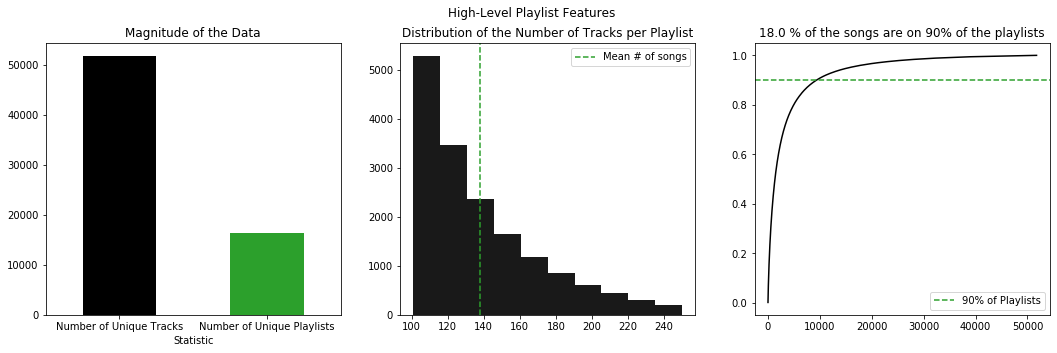

In [19]:
fig, ax = plt.subplots(1,3, figsize = (18,5))

ax[0].set_title('Magnitude of the Data')
summary_stats.plot.bar(x = 'Statistic', y='Value', rot=0, color = ['k','C02'], legend = False, ax = ax[0])

ax[1].set_title('Distribution of the Number of Tracks per Playlist')
ax[1].hist(pid_stats, color = 'k', alpha = 0.9)
ax[1].axvline(pid_stats.mean(), ls = '--', color = 'C02', label = 'Mean # of songs')
ax[1].legend()

ax[2].set_title(f'{cum_px} % of the songs are on 90% of the playlists')
ax[2].plot(np.arange(n_tracks), weighted_track_uri_stats, c = 'k')
ax[2].axhline(0.9, ls = '--', color = 'C02', label = '90% of Playlists')
ax[2].legend()
plt.suptitle('High-Level Playlist Features')
plt.show()

The plots above show immediately the impact of our playlist selection criteria on the dataset that will be used for training, testing, and validating our models.
* The number of songs per playlist is not normally distributed, and we only have playlists that include more than 100 songs.
* 18% of songs are on 90% of playlists. So we can expect overlap of songs between playlists.

### What do songs sound like?

In [ ]:
song_feature_cols = ['acousticness', 'danceability', 'duration_ms',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

song_subset_df = songs_df[song_feature_cols]

In [ ]:
columns = song_subset_df.columns
song_subset_df.hist(figsize=(21,14), column = columns)
plt.suptitle('Is there significant variation in song features?')
plt.show()

In [ ]:
scaler = MinMaxScaler().fit(song_subset_df)
scaled_songs_df = pd.DataFrame(scaler.transform(song_subset_df), columns = columns)
scaled_songs_df.boxplot(figsize=(21,7))
plt.suptitle('Is there significant variation in song features?')
plt.show()

### Do playlists tend to have very similar songs, or very different songs?

We wanted to know whether playlists in our training set tend to be built from songs that are similar to each other or songs that are different from each other. If playlists tend to be composes of songs that all have similar features, we could use information about the distribution of feature scores in a stub playlist to recommend additional songs for the playlist.

In [ ]:
subset_cols = ['pid', 'acousticness', 'danceability', 'duration_ms', 'count',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

subset_df = combined_df[subset_cols]

In [ ]:
def process_playlists(df, fun, along):
    index = df.eval(along).unique()
    columns = df.columns[df.columns != along]
    n_rows = len(index)
    n_columns = len(columns)
    
    # Construct output df
    output = pd.DataFrame(np.zeros((n_rows, n_columns)), index = index, columns = columns)

    # Loop through playslists and apply function
    for playlist in index:
        subset = df.loc[df['pid'] == playlist, columns]
        output.loc[playlist,:] = fun(subset)
    return output

In [ ]:
def gini(x):
    # Mean absolute difference
    mad = x.mad()
    mean = x.mean()
    
    # Relative mean absolute difference
    rmad = abs(mad/mean)
    
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [ ]:
playlist_ginis = process_playlists(subset_df, gini, 'pid')

In [ ]:
systemwide_playlist_ginis = gini(subset_df.groupby(['pid']).mean())
systemwide_playlist_ginis

In [ ]:
ax = playlist_ginis.mean().plot.barh()
ax.set_ylabel('Track Feature')
ax.set_xlabel('Gini Coefficient (0 = Perfect Equality)')
plt.title('Do playlists tend to have songs with similar features?')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(21, 5)) 
sns.violinplot(ax = ax, data = playlist_ginis, orient = 'v' )
ax.set_xlabel('Track Feature')
ax.set_ylabel('Gini Coefficient (0 = Perfect Equality)')
plt.title('Do playlists tend to have songs with similar features?')
plt.show()

In [ ]:
song_feature_cols = ['acousticness', 'danceability', 'duration_ms', 'count',
               'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness',
               'tempo', 'time_signature', 'valence']

In [ ]:
fig, ax = plt.subplots(figsize = (9,4.5))
ax = sns.scatterplot(playlist_ginis.mean(), systemwide_playlist_ginis, s = 75, hue = song_feature_cols)
ax.set_ylabel('Similarity Between Playlists (0 = Perfect Equality)')
ax.set_xlabel('Similarity Within Playlists (0 = Perfect Equality)')
ax.legend(title = 'Track Feature')
plt.title('Do track features differentiate playlists?')
plt.show()